# Tutorial: A Gaussian Mixture Model

In this tutorial, we demonstrate how to use the `GaussianMixture` class:

- Fit the GMM with various covariance types (full, diag, spherical, tied).
- Explore different initialization methods (random, points, kpp, kmeans, maxdist).
- Visualize model results, including responsibilities and generated samples.

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
import importlib
import os
import sys
sys.path.append('../../..')
#print(os.listdir("../../.."))

import utils.gmm
import utils.metrics
importlib.reload(utils.gmm)
importlib.reload(utils.metrics)
from utils.gmm import GaussianMixture

device = 'cuda' if torch.cuda.is_available() else 'cpu'
random_state = 0
np.random.seed(random_state)
torch.manual_seed(random_state)


Let's generate four clusters in 2D with different covariances.

In [10]:
n_samples = [1000, 1000, 1000, 1000]
centers = [np.array([0, 0]),
           np.array([0, 2]),
           np.array([2, 0]),
           np.array([2, 2])]
covs = [
    np.array([[0.0, -0.5], [1.5, 0.5]]),  # full covariance example
    0.7 * np.eye(2),                      # spherical-like
    0.5 * np.eye(2),                      # smaller spherical-like
    np.array([[0.0, 0.2], [0.4, 1.7]])    # full covariance example
]

components = []
for n, center, cov in zip(n_samples, centers, covs):
    # Generate multivariate normal data
    samples = np.dot(np.random.randn(n, 2), cov) + center
    components.append(samples)

X = np.vstack(components)  # shape (4000, 2)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

n_features = X.shape[1]
n_components = len(n_samples)

In [11]:
def plot_gmm_results(
    gmm,
    X,
    labels,
    ax=None,
    title='GMM Results',
    init_means=None
):
    """
    Plot data points colored by cluster, the final GMM ellipses,
    and optionally the initial means in red.

    Parameters
    ----------
    gmm : GaussianMixture
        A fitted GaussianMixture instance.
    X : np.ndarray
        Original 2D data (shape: (N, 2)).
    labels : np.ndarray
        Predicted cluster labels for each point in X.
    ax : matplotlib.axes.Axes
        Axes on which to plot. If None, uses current Axes.
    title : str
        Title for the subplot.
    init_means : torch.Tensor or None
        Initial means (k, 2) if you want to display them in red '+'.
    """
    if ax is None:
        ax = plt.gca()

    # Distinct colors for each cluster
    cmap = ListedColormap(plt.cm.tab10(np.linspace(0, 1, gmm.n_components)))

    # Plot data points by predicted labels
    for i, color in zip(range(gmm.n_components), cmap.colors):
        mask = (labels == i)
        ax.scatter(X[mask, 0], X[mask, 1], c=[color], s=2, label=f'Cluster {i}', alpha=0.6)

    # Plot final means & covariances
    for n, color in zip(range(gmm.n_components), cmap.colors):
        mean = gmm.means_[n].detach().cpu().numpy()

        # Determine the covariance based on gmm.covariance_type
        if gmm.covariance_type == 'full':
            cov = gmm.covariances_[n].detach().cpu().numpy()
        elif gmm.covariance_type == 'diag':
            diag_vals = gmm.covariances_[n].detach().cpu().numpy()
            cov = np.diag(diag_vals)
        elif gmm.covariance_type == 'spherical':
            var = gmm.covariances_[n].detach().cpu().item()  # scalar
            cov = np.eye(gmm.n_features) * var
        elif gmm.covariance_type == 'tied_full':
            cov = gmm.covariances_.detach().cpu().numpy()  # single shared matrix
        elif gmm.covariance_type == 'tied_diag':
            diag_vals = gmm.covariances_.detach().cpu().numpy()
            cov = np.diag(diag_vals)
        elif gmm.covariance_type == 'tied_spherical':
            var = gmm.covariances_.detach().cpu().item()
            cov = np.eye(gmm.n_features) * var
        else:
            raise ValueError(f"Unsupported covariance_type: {gmm.covariance_type}")

        # Decompose covariance to plot an ellipse
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        # Plot ellipses for 1,2,3 std devs
        for std_dev, alpha_ellipse in zip([1, 2, 3], [0.3, 0.2, 0.1]):
            width, height = 2 * np.sqrt(vals) * std_dev
            e = Ellipse(
                mean,
                width=width,
                height=height,
                angle=angle,
                facecolor=color,
                alpha=alpha_ellipse,
                edgecolor=None
            )
            ax.add_patch(e)

        # Mark final mean as black circle
        ax.plot(mean[0], mean[1], 'ko', markersize=4)

    # Optionally plot the initial means in red
    if init_means is not None:
        init_means_cpu = init_means.detach().cpu().numpy()
        for i in range(gmm.n_components):
            ax.plot(init_means_cpu[i, 0], init_means_cpu[i, 1],
                    'r+', markersize=10, markeredgewidth=2)

    ax.set_title(title)
    ax.axis('equal')


In [12]:
# Initialize the GMM
gmm = GaussianMixture(
    n_features=n_features,
    n_components=n_components,
    covariance_type='full',
    tol=1e-4,
    reg_covar=1e-6,
    max_iter=1000,
    init_params='random',
    cov_init_method='eye',
    weights_init=None,
    means_init=None,
    covariances_init=None,
    n_init = 5,
    random_state=None,
    warm_start=False,
    verbose=True,
    verbose_interval=10,
    device='cpu',
)
# Fit the GMM
gmm.fit(X_tensor)

# Get predictions
y_pred = gmm.predict(X_tensor)

# Compute per-sample log-likelihoods
log_probs = gmm.score_samples(X_tensor)

# Get probabilities for each sample for each component
probs = gmm.predict_proba(X_tensor)
probs = probs.detach()

# Generate new samples
n_samples_to_generate = 4000
gmm_samples, gmm_labels = gmm.sample(n_samples_to_generate)
gmm_samples = gmm_samples.detach().cpu().numpy()
gmm_labels = gmm_labels.detach().cpu().numpy()

# Compute probabilities for each generated sample
generated_probs = gmm.predict_proba(torch.tensor(gmm_samples, dtype=torch.float32).to(device))
generated_probs = generated_probs.detach().cpu().numpy()

print('Mean per-sample log-likelihood:', gmm.score(X_tensor))
print('Std per-sample log-likelihood:', torch.std(log_probs).item())
print('Lower bound:', gmm.lower_bound_)
print('Number of iterations:', gmm.n_iter_)
print('Sum of log-likelihoods:', torch.sum(log_probs).item())


[InitRun 0] Iter 0, lower bound: -5.38992
[InitRun 0] Iter 10, lower bound: -3.21788
[InitRun 0] Iter 20, lower bound: -3.18038
[InitRun 0] Iter 30, lower bound: -2.77929
[InitRun 0] Converged at iteration 38, lower bound=-2.73262
[InitRun 1] Iter 0, lower bound: -3.91078
[InitRun 1] Iter 10, lower bound: -3.17127
[InitRun 1] Iter 20, lower bound: -3.12612
[InitRun 1] Iter 30, lower bound: -2.74164
[InitRun 1] Converged at iteration 38, lower bound=-2.73285
[InitRun 2] Iter 0, lower bound: -4.41680
[InitRun 2] Iter 10, lower bound: -3.22166
[InitRun 2] Iter 20, lower bound: -3.20861
[InitRun 2] Iter 30, lower bound: -3.20091
[InitRun 2] Iter 40, lower bound: -2.74187
[InitRun 2] Converged at iteration 50, lower bound=-2.73273
[InitRun 3] Iter 0, lower bound: -4.80912
[InitRun 3] Iter 10, lower bound: -3.16844
[InitRun 3] Iter 20, lower bound: -3.06464
[InitRun 3] Iter 30, lower bound: -2.73293
[InitRun 3] Converged at iteration 31, lower bound=-2.73272
[InitRun 4] Iter 0, lower bound: 

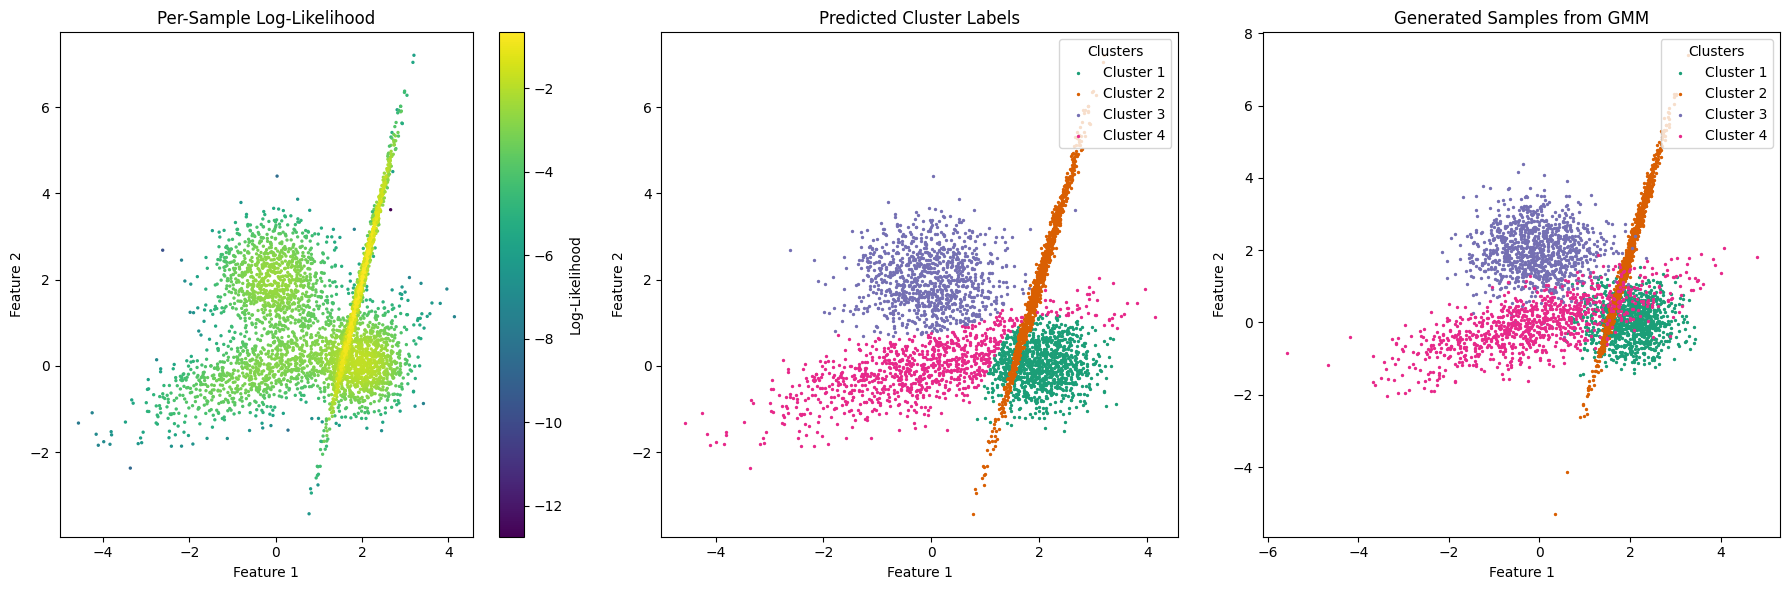

In [13]:
# Define your color map for up to 4 components (adjust if needed)
colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']
color_map = {label: color for label, color in enumerate(colors)}

# 1) Prepare your figure
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

###############################################################################
# Plot (1) - Per-Sample Log-Likelihood
###############################################################################

scatter = axs[0].scatter(
    X[:, 0], 
    X[:, 1], 
    c=log_probs, 
    cmap='viridis', 
    s=2
)
axs[0].set_title('Per-Sample Log-Likelihood')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')
cbar = fig.colorbar(scatter, ax=axs[0])
cbar.set_label('Log-Likelihood')

###############################################################################
# Plot (2) - Predicted Cluster Labels
###############################################################################

for cluster in range(n_components):
    cluster_points = X[y_pred == cluster]
    axs[1].scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        label=f'Cluster {cluster + 1}',
        color=color_map[cluster],
        s=2
    )

axs[1].set_title('Predicted Cluster Labels')
axs[1].set_xlabel('Feature 1')
axs[1].set_ylabel('Feature 2')
axs[1].legend(title="Clusters", loc='upper right')

###############################################################################
# Plot (3) - Generated Samples from the GMM
###############################################################################

for cluster in range(n_components):
    cluster_samples = gmm_samples[gmm_labels == cluster]
    axs[2].scatter(
        cluster_samples[:, 0],
        cluster_samples[:, 1],
        label=f'Cluster {cluster + 1}',
        color=color_map[cluster],
        s=2
    )

axs[2].set_title('Generated Samples from GMM')
axs[2].set_xlabel('Feature 1')
axs[2].set_ylabel('Feature 2')
axs[2].legend(title="Clusters", loc='upper right')

###############################################################################
# Final Layout & Save
###############################################################################
plt.tight_layout()
plt.show()


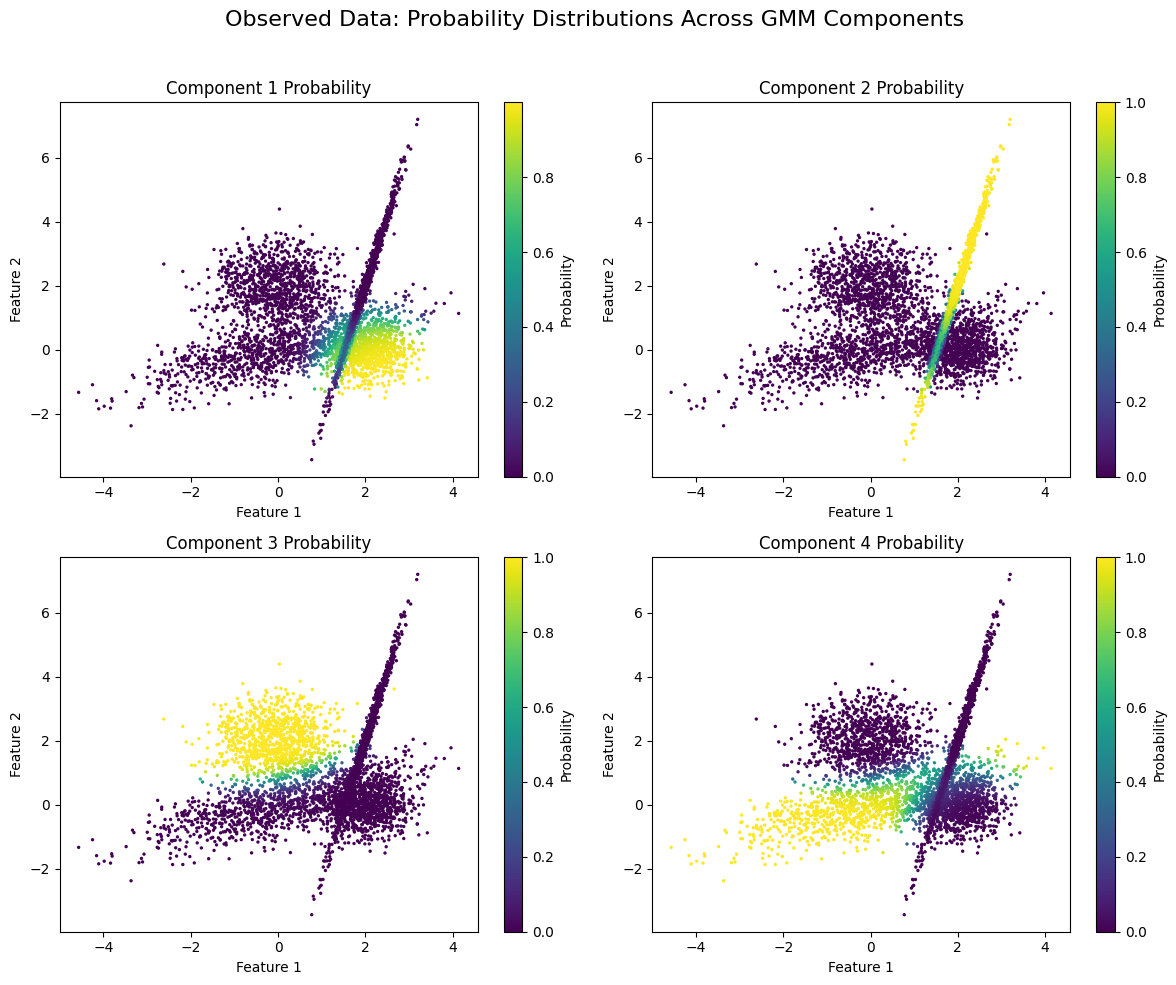

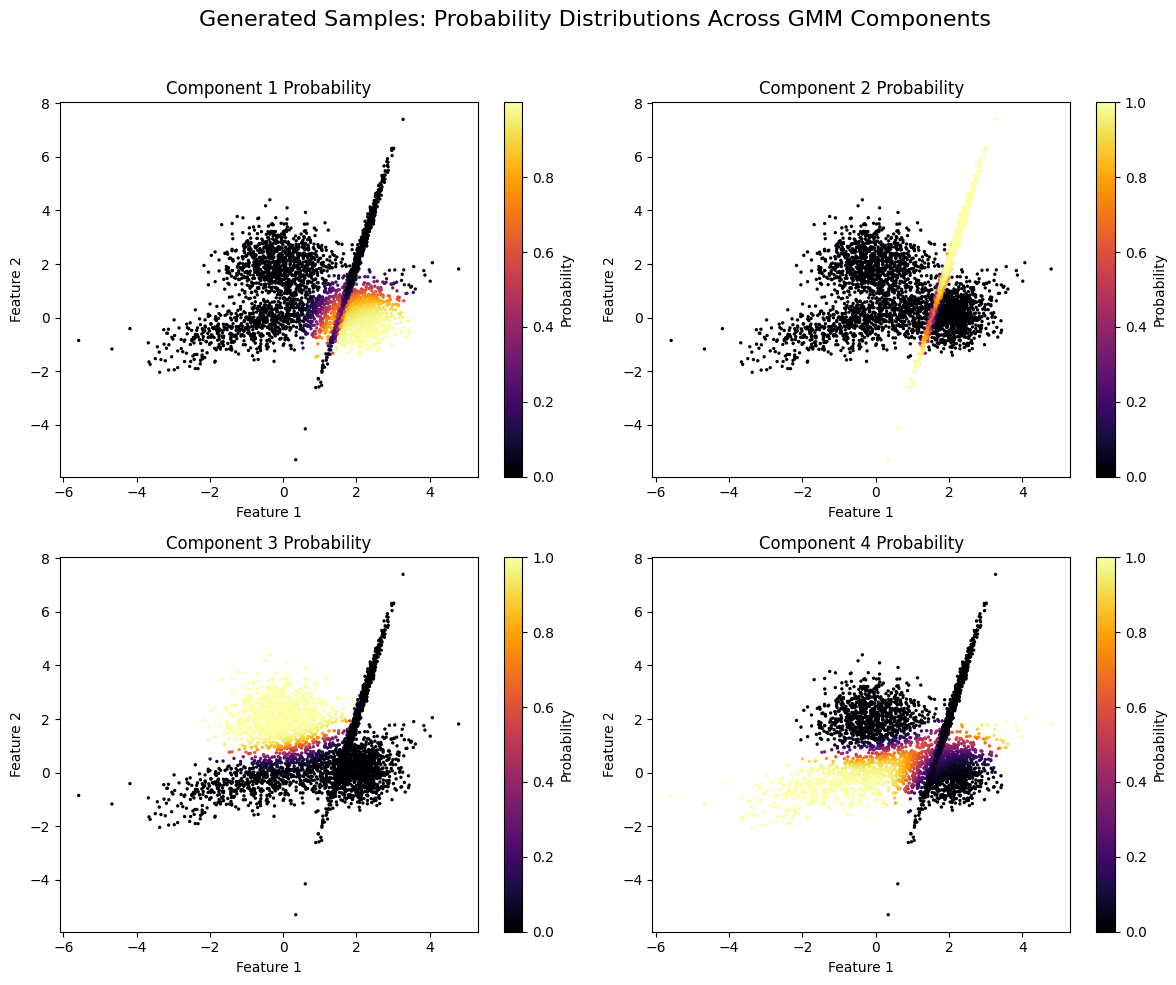

In [14]:
# Observed Data
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for k, ax in enumerate(axs.ravel()):
    prob_k = probs[:, k]
    scatter = ax.scatter(X[:, 0], X[:, 1], c=prob_k.detach().cpu().numpy(), cmap='viridis', s=2)
    ax.set_title(f'Component {k+1} Probability')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Probability')

fig.suptitle("Observed Data: Probability Distributions Across GMM Components", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Generated Samples
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for k, ax in enumerate(axs.ravel()):
    prob_k = generated_probs[:, k]
    scatter = ax.scatter(gmm_samples[:, 0], gmm_samples[:, 1], c=prob_k, cmap='inferno', s=2)
    ax.set_title(f'Component {k+1} Probability')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Probability')

fig.suptitle("Generated Samples: Probability Distributions Across GMM Components", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


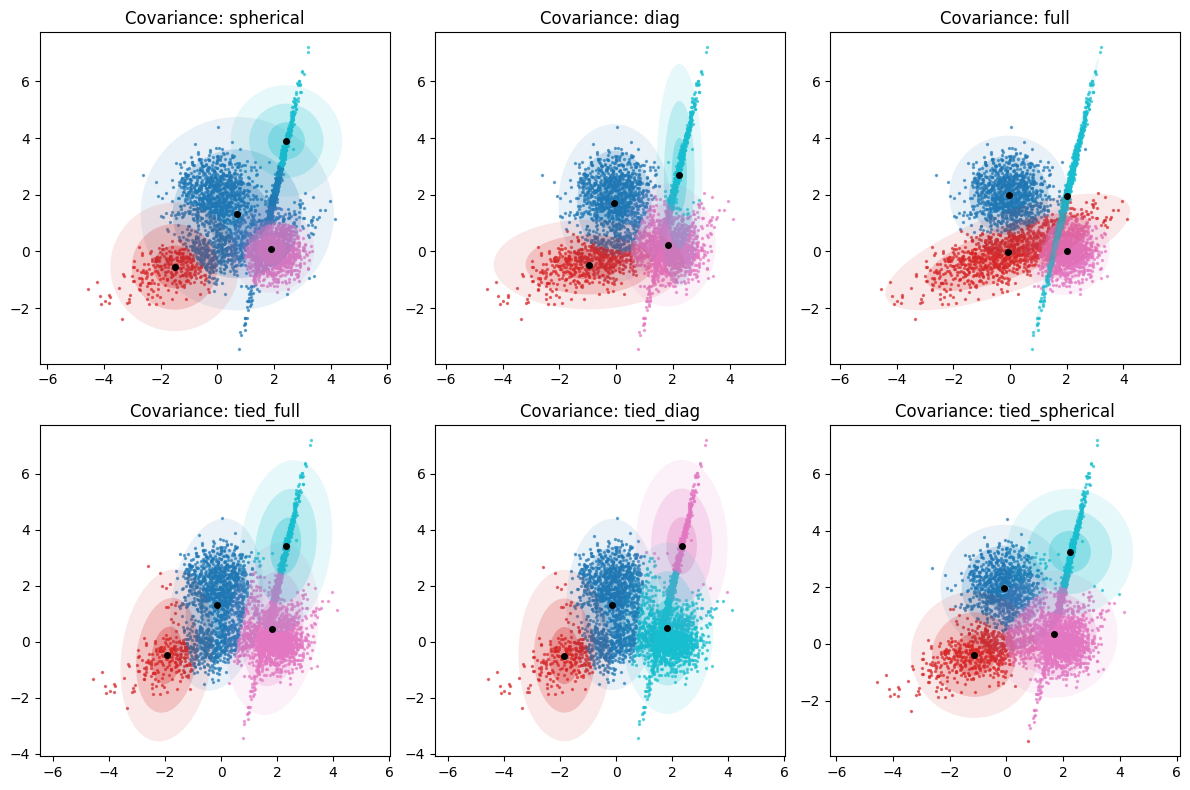

In [15]:
cov_types = ['spherical', 'diag', 'full', 'tied_full', 'tied_diag', 'tied_spherical']

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

for ax, cov_type in zip(axs, cov_types):
    gmm = GaussianMixture(
        n_features=2,
        n_components=4,
        covariance_type=cov_type,
        init_params='kmeans',
        random_state=random_state,
        device=device
    )
    gmm.fit(X_tensor)
    labels_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm_results(gmm, X, labels_pred, ax=ax, title=f'Covariance: {cov_type}')

plt.tight_layout()
plt.show()

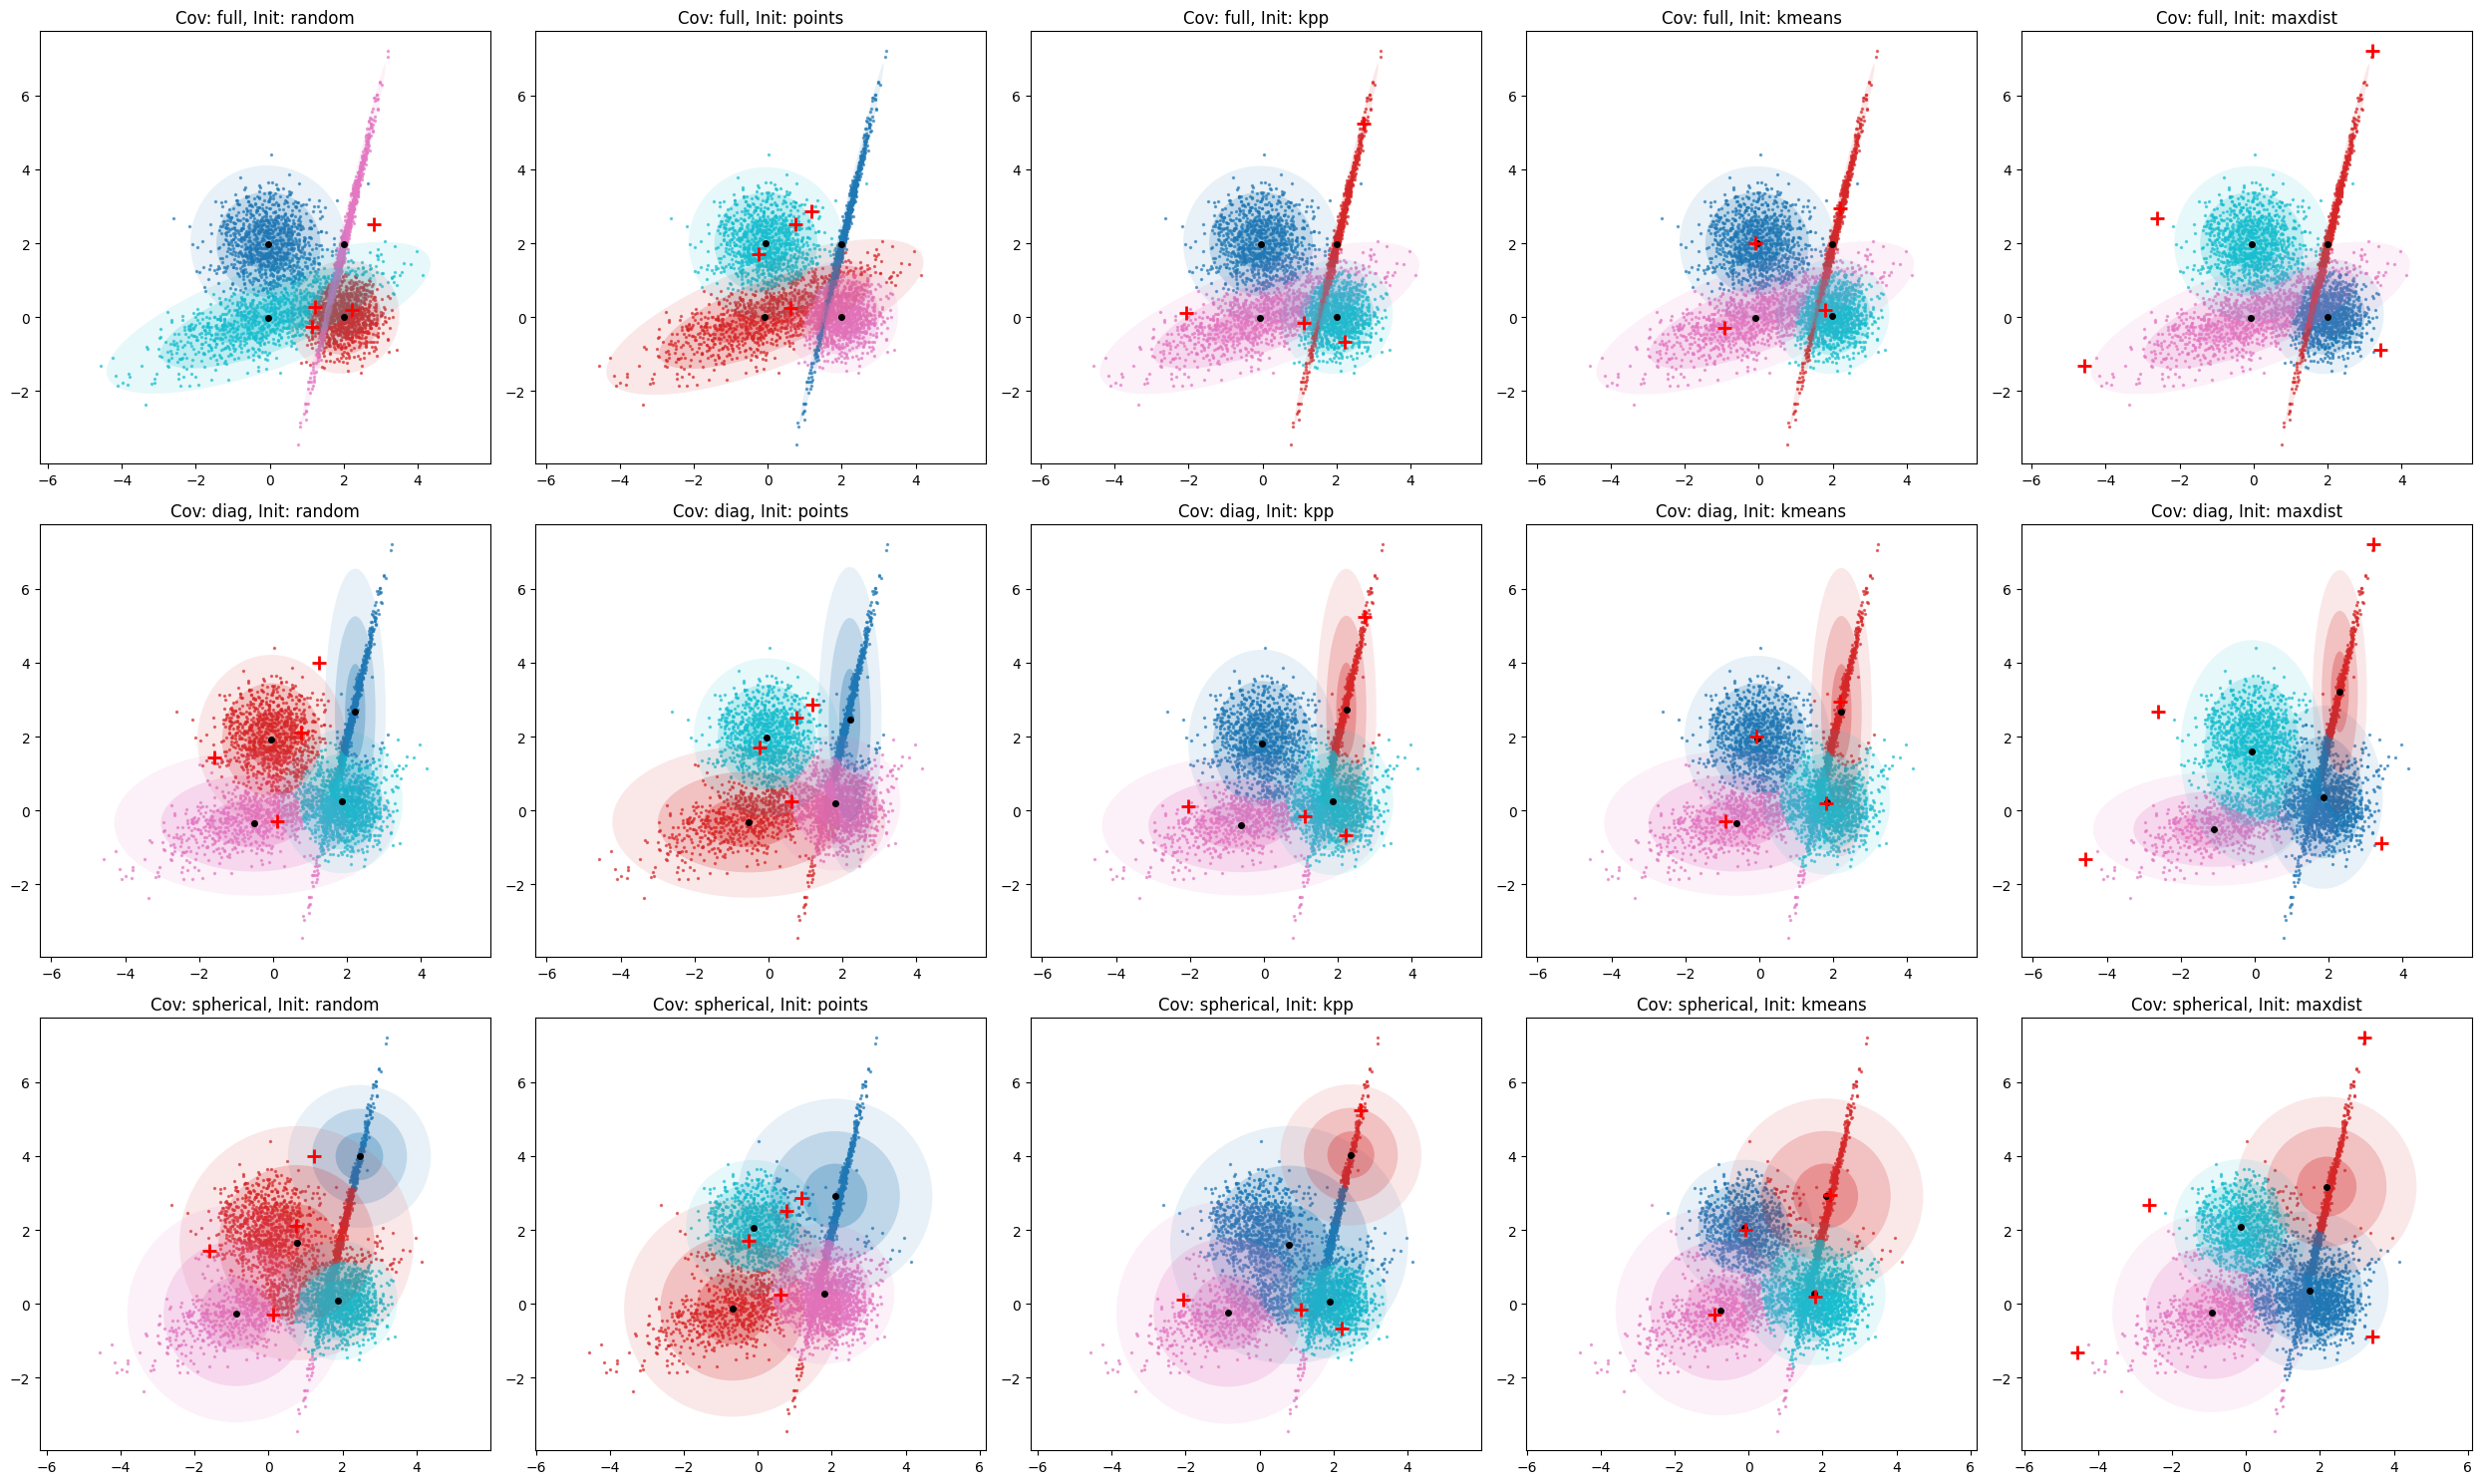

In [16]:
cov_types = ['full', 'diag', 'spherical']
init_methods = ['random', 'points', 'kpp', 'kmeans', 'maxdist']


from utils.gmm_init import GMMInitializer

def get_init_means(method, data, k):
    """
    Returns initial means for a given method from GMMInitializer.
    """
    if method == 'random':
        return GMMInitializer.random(data, k)
    elif method == 'points':
        return GMMInitializer.points(data, k)
    elif method == 'kpp':
        return GMMInitializer.kpp(data, k)
    elif method == 'kmeans':
        return GMMInitializer.kmeans(data, k)
    elif method == 'maxdist':
        return GMMInitializer.maxdist(data, k)
    else:
        raise ValueError(f"Unknown init method: {method}")


import matplotlib.pyplot as plt

cov_types = ['full', 'diag', 'spherical']
init_methods = ['random', 'points', 'kpp', 'kmeans', 'maxdist']

fig, axs = plt.subplots(
    nrows=len(cov_types),
    ncols=len(init_methods),
    figsize=(25, 15)  # adjust as you like
)

for row_idx, cov_type in enumerate(cov_types):
    for col_idx, method in enumerate(init_methods):
        ax = axs[row_idx, col_idx]

        # 1) Get initial means from our GMMInitializer
        init_means = get_init_means(method, X_tensor, k=4)

        # 2) Create GMM with 'means_init' so it uses these means
        gmm = GaussianMixture(
            n_features=2,
            n_components=4,
            covariance_type=cov_type,
            means_init=init_means,
            init_params=None,      # or 'none' to bypass internal logic
            random_state=42,
            device=device
        )

        # 3) Fit the GMM on X_tensor
        gmm.fit(X_tensor)
        # 4) Predict cluster labels
        labels_pred = gmm.predict(X_tensor).cpu().numpy()

        # 5) Plot
        title = f'Cov: {cov_type}, Init: {method}'
        plot_gmm_results(gmm, X, labels_pred, ax=ax, title=title, init_means=init_means)

plt.tight_layout()
plt.show()
